<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import torch.nn.functional as F
import util
import layers
import os
import logging
import numpy as np
import pandas as pd
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm as tqdm

import torchaudio

from matplotlib import pyplot as pylab

# %pylab inline

E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torchaudio\backend\utils.py:64: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  'The interface of "soundfile" backend is planned to change in 0.8.0 to '


In [2]:
import IPython.display as ipd
import numpy as np

In [3]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
from torchvision import models
from torchsummary import summary

# vgg = models.vgg16()
# vgg.to(dev)
# summary(vgg, (3, 224, 224))

In [5]:
config = {
    "dataset": {
        "extract_voice": True,
        "in_memory_percentage": 1,
        "noise_only_percent": 0.1,
        "num_condition_classes": 29,
        "path": "data/NSDTSEA/",
        "regain": 0.06,
        "sample_rate": 16000,
        "type": "nsdtsea"
    },
    "model": {
        "condition_encoding": "binary",
        "dilations": 9,
        "filters": {
            "lengths": {
                "res": 3,
                "final": [3, 3],
                "skip": 1
            },
            "depths": {
                "res": 128,
                "skip": 128,
                "final": [2048, 256]
            }
        },
        "num_stacks": 3,
        "target_field_length": 1601,
        "target_padding": 1
    },
    "optimizer": {
        "decay": 0.0,
        "epsilon": 1e-08,
        "lr": 0.001,
        "momentum": 0.9,
        "type": "adam"
    },
    "training": {
        "batch_size": 10,
        "early_stopping_patience": 16,
        "loss": {
            "out_1": {
                "l1": 1,
                "l2": 0,
                "weight": 1
            },
            "out_2": {
                "l1": 1,
                "l2": 0,
                "weight": 1
            }
        },
        "num_epochs": 250,
        "num_test_samples": 100,
        "num_train_samples": 1000,
        "path": "data/NSDTSEA/"
    }
}

In [6]:
class dilated_residual_block(nn.Module):
    
    def __init__(self, dilation, input_length, padded_target_field_length, config):
        super().__init__()
        self.dilation =  dilation
        self.input_length = input_length
#         self.condition_input_length = condition_input_length
#         self.samples_of_interest_indices = samples_of_interest_indices
        self.padded_target_field_length = padded_target_field_length
        self.config = config
        self.conv1 = nn.Conv1d(self.config['model']['filters']['depths']['res'], 2*self.config['model']['filters']['depths']['res'],
                               kernel_size = self.config['model']['filters']['lengths']['res'], stride=1, bias = False, dilation = self.dilation,
                               padding=int(self.dilation))
        self.conv2 = nn.Conv1d(self.config['model']['filters']['depths']['res'], 
                               self.config['model']['filters']['depths']['res'] + self.config['model']['filters']['depths']['skip'],
                               1, stride=1, bias = False, padding=0)
        
    
    def forward(self, data_x):

        original_x = data_x

        # Data sub-block
        data_out = self.conv1(data_x)

        data_out_1 = layers.slicing(data_out, slice(0, self.config['model']['filters']['depths']['res'],1), 1) 

        data_out_2 = layers.slicing(data_out, slice(self.config['model']['filters']['depths']['res'], 
                                                    2*self.config['model']['filters']['depths']['res'],1), 1)

        data_out_1 = data_out_1
        
        data_out_2 = data_out_2

        tanh_out = torch.tanh(data_out_1)
        sigm_out = torch.sigmoid(data_out_2)

        data_x = tanh_out*sigm_out

        data_x = self.conv2(data_x)

        res_x = layers.slicing(data_x, slice(0, self.config['model']['filters']['depths']['res'],1), 1)
        
        skip_x = layers.slicing(data_x, slice(self.config['model']['filters']['depths']['res'], 
                                self.config['model']['filters']['depths']['res']+self.config['model']['filters']['depths']['skip'],1), 1)

        res_x = res_x + original_x

        return res_x, skip_x

In [7]:
drb = dilated_residual_block(9, 100, 100, config)
# drb.to(dev)

In [8]:
summary(drb, (128, 3))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [8]:
drb

dilated_residual_block(
  (conv1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(9,), dilation=(9,), bias=False)
  (conv2): Conv1d(128, 256, kernel_size=(1,), stride=(1,), bias=False)
)

In [8]:
class DenoisingWavenet(nn.Module):

    def __init__(self, config, input_length=None, target_field_length=None):
        super().__init__()

        self.config = config
        self.num_stacks = self.config['model']['num_stacks']
        if type(self.config['model']['dilations']) is int:
            self.dilations = [2 ** i for i in range(0, self.config['model']['dilations'] + 1)]
        elif type(self.config['model']['dilations']) is list:
            self.dilations = self.config['model']['dilations']

        self.receptive_field_length = util.compute_receptive_field_length(config['model']['num_stacks'], self.dilations, config['model']['filters']['lengths']['res'], 1)

        if input_length is not None:
            self.input_length = int(input_length)
            self.target_field_length = int(self.input_length - (self.receptive_field_length - 1))
        if target_field_length is not None:
            self.target_field_length = int(target_field_length)
            self.input_length = int(self.receptive_field_length + (self.target_field_length - 1))
        else:
            self.target_field_length = int(config['model']['target_field_length'])
            self.input_length = int(self.receptive_field_length + (self.target_field_length - 1))

        self.target_padding = config['model']['target_padding']
        self.padded_target_field_length = self.target_field_length + 2 * self.target_padding
        self.half_target_field_length = int(self.target_field_length / 2)
        self.half_receptive_field_length = int(self.receptive_field_length / 2)
        self.num_residual_blocks = len(self.dilations) * self.num_stacks

        self.config['model']['num_residual_blocks'] = self.num_residual_blocks
        self.config['model']['receptive_field_length'] = self.receptive_field_length
        self.config['model']['input_length'] = self.input_length
        self.config['model']['target_field_length'] = self.target_field_length
        
        # Layers in the model
        self.conv1 = nn.Conv1d(1, self.config['model']['filters']['depths']['res'], self.config['model']['filters']['lengths']['res'], stride=1, bias = False, padding=1)
        
        self.conv2 = nn.Conv1d(self.config['model']['filters']['depths']['res'], self.config['model']['filters']['depths']['final'][0], self.config['model']['filters']['lengths']['final'][0], stride=1, bias = False, padding=1)
        
        self.conv3 = nn.Conv1d(self.config['model']['filters']['depths']['final'][0], self.config['model']['filters']['depths']['final'][1], self.config['model']['filters']['lengths']['final'][1], stride=1, bias = False, padding=1)
        
        self.conv4 = nn.Conv1d(self.config['model']['filters']['depths']['final'][1], 1, 1, stride=1, bias = False, padding=0)
        
        self.dilated_layers = nn.ModuleList([dilated_residual_block(dilation, self.input_length, self.padded_target_field_length, self.config) for dilation in self.dilations])


    def get_target_field_indices(self):

        target_sample_index = self.get_target_sample_index()

        return range(target_sample_index - self.half_target_field_length,
                     target_sample_index + self.half_target_field_length + 1)

    def get_padded_target_field_indices(self):

        target_sample_index = self.get_target_sample_index()

        return range(target_sample_index - self.half_target_field_length - self.target_padding,
                     target_sample_index + self.half_target_field_length + self.target_padding + 1)

    def get_target_sample_index(self):
        return int(np.floor(self.input_length / 2.0))

    def get_condition_input_length(self, representation):

        if representation == 'binary':
            return int(np.ceil(np.log2(self.num_condition_classes)))
        else:
            return self.num_condition_classes

    def forward(self, x):

        data_input = x#['data_input']

        data_expanded = layers.expand_dims(data_input, 1)
        
        data_out = self.conv1(data_expanded)

        skip_connections = []
        for _ in range(self.num_stacks):
            for layer in self.dilated_layers:
                data_out, skip_out = layer(data_out)
                if skip_out is not None:
                    skip_connections.append(skip_out)

        data_out = torch.stack( skip_connections, dim = 0).sum(dim = 0)
        data_out = F.relu(data_out)

        data_out = self.conv2(data_out)

        data_out = F.relu(data_out)
        
        data_out = self.conv3(data_out)

        data_out = self.conv4(data_out)

        data_out_speech = data_out
        data_out_noise = data_input - data_out_speech

        data_out_speech = data_out_speech.squeeze_(1)

        data_out_noise = data_out_noise.squeeze_(1)

        return data_out_speech#, data_out_noise

In [9]:
dw = DenoisingWavenet(config)

In [10]:
dw.to(dev)

DenoisingWavenet(
  (conv1): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv2): Conv1d(128, 2048, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv3): Conv1d(2048, 256, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv4): Conv1d(256, 1, kernel_size=(1,), stride=(1,), bias=False)
  (dilated_layers): ModuleList(
    (0): dilated_residual_block(
      (conv1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (conv2): Conv1d(128, 256, kernel_size=(1,), stride=(1,), bias=False)
    )
    (1): dilated_residual_block(
      (conv1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
      (conv2): Conv1d(128, 256, kernel_size=(1,), stride=(1,), bias=False)
    )
    (2): dilated_residual_block(
      (conv1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,), bias=False)
      (conv2): Conv1d(128, 256, kernel_size=(1,), stride=(1,), bias=

In [11]:
summary(dw, (30000,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [-1, 128, 30000]             384
            Conv1d-2           [-1, 256, 30000]          98,304
            Conv1d-3           [-1, 256, 30000]          32,768
dilated_residual_block-4  [[-1, 128, 30000], [-1, 128, 30000]]               0
            Conv1d-5           [-1, 256, 30000]          98,304
            Conv1d-6           [-1, 256, 30000]          32,768
dilated_residual_block-7  [[-1, 128, 30000], [-1, 128, 30000]]               0
            Conv1d-8           [-1, 256, 30000]          98,304
            Conv1d-9           [-1, 256, 30000]          32,768
dilated_residual_block-10  [[-1, 128, 30000], [-1, 128, 30000]]               0
           Conv1d-11           [-1, 256, 30000]          98,304
           Conv1d-12           [-1, 256, 30000]          32,768
dilated_residual_block-13  [[-1, 128, 30000], [-1, 128, 3

E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in long_scalars
  total_output += np.prod(summary[layer]["output_shape"])


In [157]:
waveform, sample_rate = torchaudio.load("wav.wav")
waveform = waveform[:1, :]
waveform = waveform.narrow(1, 0, 19968).T#.view(2,-1,1)#.squeeze()
waveform.shape, sample_rate

(torch.Size([19968, 1]), 8000)

In [158]:
inter = torch.stft(waveform.squeeze(), n_fft=512, return_complex=True)
inter.shape, inter.shape[0]*inter.shape[1]

(torch.Size([257, 157]), 40349)

In [32]:
waveform.squeeze().shape

torch.Size([19968])

In [45]:
waveform.shape

torch.Size([19968, 1])

In [34]:
waveform[(0, 1), (0, 2)]

IndexError: index 2 is out of bounds for dimension 1 with size 1

In [127]:
# ll = [(np.random.randint(0, inter.shape[0]), np.random.randint(0, inter.shape[1])) for i in range(5000)]
# inter[list(zip(*ll))] = 0
ll = torch.randint(inter.shape[1], (2, 100))
inter[ll] = 0
waveform_n = torch.istft(inter, n_fft=512)
inter.shape

torch.Size([257, 157])

In [162]:
bb = torch.randint(inter.shape[0], (1, 100))
ll = torch.randint(inter.shape[1], (1, 100))
ll = torch.cat((bb, ll))
ll.numpy()
inter[ll] = 0
waveform_n = torch.istft(inter, n_fft=512)
inter.shape

torch.Size([257, 157])

In [52]:
for i in range(50000):
    i, j = np.random.randint(0, inter.shape[0]), np.random.randint(0, inter.shape[1])
    inter[i, j] = 0
waveform_n = torch.istft(inter, n_fft=512)

In [96]:
# noise = np.random.normal(0, 0.01, waveform.shape)
# waveform = waveform+noise

In [161]:
display(ipd.Audio(waveform_n.T, rate=sample_rate));

In [58]:
waveform_n.shape

torch.Size([19968])

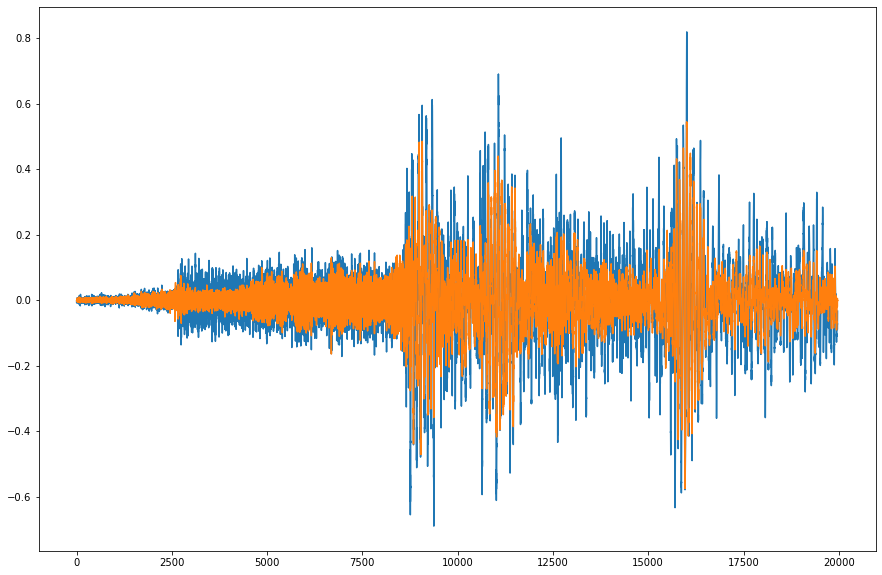

In [160]:
pylab.figure(figsize=(15, 10))

pylab.plot(waveform.squeeze())

# pylab.plot(y.cpu().detach().numpy().squeeze())
# pylab.plot(x.cpu().detach().numpy().squeeze())
pylab.plot(waveform_n.squeeze())

In [58]:
model = DenoisingWavenet(config).to(dev)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

In [99]:
waveform, sample_rate = torchaudio.load("wav.wav")
waveform = waveform[:1, :]
waveform = torch.tensor(waveform.narrow(1, 0, 19968).T, dtype=torch.float32)
# noise = np.array(np.random.normal(0, 0.01, waveform.shape), dtype="double")
# waveform_n = torch.tensor(waveform+noise, dtype=torch.float32)

inter = torch.stft(waveform.squeeze(), n_fft=512, return_complex=True)
inter.shape, inter.shape[0]*inter.shape[1]
for i in range(50000):
    i, j = np.random.randint(0, inter.shape[0]), np.random.randint(0, inter.shape[1])
    inter[i, j] = 0
waveform_n = torch.istft(inter, n_fft=512)

train_losses = []

for epoch in tqdm(range(1, 50)):
    counter = 0
    model.train()
    batch_losses=[]
    batch_metric=[]
    data = waveform.view(1, -1)
    data_n = waveform_n.view(1, -1)
    while True:
        print(counter, end='\r')
        x, y = torch.clone(data_n).to(dev), torch.clone(data).to(dev)
        optimizer.zero_grad()
#         x = dict(map(lambda i: (i[0], i[1].to(self.device, dtype=torch.float32)), x.items()))
#         y = dict(map(lambda i: (i[0], i[1].to(self.device, dtype=torch.float32)), y.items()))
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        batch_losses.append(loss)
        optimizer.step()
        if counter >= 1:
            break
        counter += 1
    train_losses.append(torch.stack(batch_losses, dim = 0).mean(dim = 0).detach().cpu().numpy())
    print(f'Epoch - {epoch} Train-Loss : {train_losses[-1]}')
    counter = 0

E:\Users\alex\anaconda3\envs\mil\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

  2%|█▋                                                                                 | 1/49 [00:00<00:21,  2.20it/s]

Epoch - 1 Train-Loss : 0.1084309071302414


  4%|███▍                                                                               | 2/49 [00:00<00:20,  2.26it/s]

Epoch - 2 Train-Loss : 0.06833219528198242


  6%|█████                                                                              | 3/49 [00:01<00:19,  2.31it/s]

Epoch - 3 Train-Loss : 0.060251250863075256


  8%|██████▊                                                                            | 4/49 [00:01<00:19,  2.33it/s]

Epoch - 4 Train-Loss : 0.05638927221298218


 10%|████████▍                                                                          | 5/49 [00:02<00:18,  2.34it/s]

Epoch - 5 Train-Loss : 0.05241779610514641


 12%|██████████▏                                                                        | 6/49 [00:02<00:18,  2.34it/s]

Epoch - 6 Train-Loss : 0.04981228709220886


 14%|███████████▊                                                                       | 7/49 [00:03<00:17,  2.35it/s]

Epoch - 7 Train-Loss : 0.04712295159697533


 16%|█████████████▌                                                                     | 8/49 [00:03<00:17,  2.35it/s]

Epoch - 8 Train-Loss : 0.0440281480550766


 18%|███████████████▏                                                                   | 9/49 [00:03<00:17,  2.35it/s]

Epoch - 9 Train-Loss : 0.04051283001899719


 20%|████████████████▋                                                                 | 10/49 [00:04<00:16,  2.33it/s]

Epoch - 10 Train-Loss : 0.037587106227874756


 22%|██████████████████▍                                                               | 11/49 [00:04<00:16,  2.33it/s]

Epoch - 11 Train-Loss : 0.034180596470832825


 24%|████████████████████                                                              | 12/49 [00:05<00:15,  2.34it/s]

Epoch - 12 Train-Loss : 0.032248273491859436


 27%|█████████████████████▊                                                            | 13/49 [00:05<00:15,  2.34it/s]

Epoch - 13 Train-Loss : 0.031932730227708817


 29%|███████████████████████▍                                                          | 14/49 [00:06<00:15,  2.33it/s]

Epoch - 14 Train-Loss : 0.02910778485238552


 31%|█████████████████████████                                                         | 15/49 [00:06<00:14,  2.32it/s]

Epoch - 15 Train-Loss : 0.026092231273651123


 33%|██████████████████████████▊                                                       | 16/49 [00:06<00:14,  2.32it/s]

Epoch - 16 Train-Loss : 0.02544746920466423


 35%|████████████████████████████▍                                                     | 17/49 [00:07<00:13,  2.32it/s]

Epoch - 17 Train-Loss : 0.025244921445846558


 37%|██████████████████████████████                                                    | 18/49 [00:07<00:13,  2.32it/s]

Epoch - 18 Train-Loss : 0.024313319474458694


 39%|███████████████████████████████▊                                                  | 19/49 [00:08<00:12,  2.32it/s]

Epoch - 19 Train-Loss : 0.02287425845861435


 41%|█████████████████████████████████▍                                                | 20/49 [00:08<00:12,  2.32it/s]

Epoch - 20 Train-Loss : 0.022803014144301414


 43%|███████████████████████████████████▏                                              | 21/49 [00:09<00:12,  2.32it/s]

Epoch - 21 Train-Loss : 0.021036142483353615


 45%|████████████████████████████████████▊                                             | 22/49 [00:09<00:11,  2.32it/s]

Epoch - 22 Train-Loss : 0.022978268563747406


 47%|██████████████████████████████████████▍                                           | 23/49 [00:09<00:11,  2.31it/s]

Epoch - 23 Train-Loss : 0.021320197731256485


 49%|████████████████████████████████████████▏                                         | 24/49 [00:10<00:10,  2.32it/s]

Epoch - 24 Train-Loss : 0.019626008346676826


 51%|█████████████████████████████████████████▊                                        | 25/49 [00:10<00:10,  2.31it/s]

Epoch - 25 Train-Loss : 0.01905164122581482


 53%|███████████████████████████████████████████▌                                      | 26/49 [00:11<00:09,  2.32it/s]

Epoch - 26 Train-Loss : 0.018326973542571068


 55%|█████████████████████████████████████████████▏                                    | 27/49 [00:11<00:09,  2.31it/s]

Epoch - 27 Train-Loss : 0.015911953523755074


 57%|██████████████████████████████████████████████▊                                   | 28/49 [00:12<00:09,  2.31it/s]

Epoch - 28 Train-Loss : 0.01592579483985901


 59%|████████████████████████████████████████████████▌                                 | 29/49 [00:12<00:08,  2.31it/s]

Epoch - 29 Train-Loss : 0.01509173959493637


 61%|██████████████████████████████████████████████████▏                               | 30/49 [00:12<00:08,  2.31it/s]

Epoch - 30 Train-Loss : 0.013443971984088421


 63%|███████████████████████████████████████████████████▉                              | 31/49 [00:13<00:07,  2.31it/s]

Epoch - 31 Train-Loss : 0.013898961246013641


 65%|█████████████████████████████████████████████████████▌                            | 32/49 [00:13<00:07,  2.31it/s]

Epoch - 32 Train-Loss : 0.012274040840566158


 67%|███████████████████████████████████████████████████████▏                          | 33/49 [00:14<00:06,  2.31it/s]

Epoch - 33 Train-Loss : 0.01258392445743084


 69%|████████████████████████████████████████████████████████▉                         | 34/49 [00:14<00:06,  2.31it/s]

Epoch - 34 Train-Loss : 0.011238658800721169


 71%|██████████████████████████████████████████████████████████▌                       | 35/49 [00:15<00:06,  2.31it/s]

Epoch - 35 Train-Loss : 0.015756109729409218


 73%|████████████████████████████████████████████████████████████▏                     | 36/49 [00:15<00:05,  2.31it/s]

Epoch - 36 Train-Loss : 0.014579666778445244


 76%|█████████████████████████████████████████████████████████████▉                    | 37/49 [00:15<00:05,  2.31it/s]

Epoch - 37 Train-Loss : 0.015689484775066376


 78%|███████████████████████████████████████████████████████████████▌                  | 38/49 [00:16<00:04,  2.31it/s]

Epoch - 38 Train-Loss : 0.016239793971180916


 80%|█████████████████████████████████████████████████████████████████▎                | 39/49 [00:16<00:04,  2.31it/s]

Epoch - 39 Train-Loss : 0.015514789149165154


 82%|██████████████████████████████████████████████████████████████████▉               | 40/49 [00:17<00:03,  2.31it/s]

Epoch - 40 Train-Loss : 0.014464055188000202


 84%|████████████████████████████████████████████████████████████████████▌             | 41/49 [00:17<00:03,  2.31it/s]

Epoch - 41 Train-Loss : 0.013177366927266121


 86%|██████████████████████████████████████████████████████████████████████▎           | 42/49 [00:18<00:03,  2.30it/s]

Epoch - 42 Train-Loss : 0.01348946988582611


 88%|███████████████████████████████████████████████████████████████████████▉          | 43/49 [00:18<00:02,  2.30it/s]

Epoch - 43 Train-Loss : 0.014768024906516075


 90%|█████████████████████████████████████████████████████████████████████████▋        | 44/49 [00:18<00:02,  2.31it/s]

Epoch - 44 Train-Loss : 0.01720185950398445


 92%|███████████████████████████████████████████████████████████████████████████▎      | 45/49 [00:19<00:01,  2.30it/s]

Epoch - 45 Train-Loss : 0.014063604176044464


 94%|████████████████████████████████████████████████████████████████████████████▉     | 46/49 [00:19<00:01,  2.30it/s]

Epoch - 46 Train-Loss : 0.013630850240588188


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 47/49 [00:20<00:00,  2.30it/s]

Epoch - 47 Train-Loss : 0.012732181698083878


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 48/49 [00:20<00:00,  2.31it/s]

Epoch - 48 Train-Loss : 0.012037045322358608


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:21<00:00,  2.32it/s]

Epoch - 49 Train-Loss : 0.011559538543224335


In [20]:
# del x, y
# torch.cuda.empty_cache()

In [100]:
y = model(waveform_n.to(dev).unsqueeze(0)).squeeze()

In [101]:
display(ipd.Audio(x.cpu().squeeze(), rate=sample_rate));

In [102]:
display(ipd.Audio(y.cpu().detach().numpy(), rate=sample_rate));

In [107]:
display(ipd.Audio(waveform.T, rate=sample_rate));

In [104]:
nnn = y.cpu().detach().numpy()-x.cpu().squeeze().numpy()

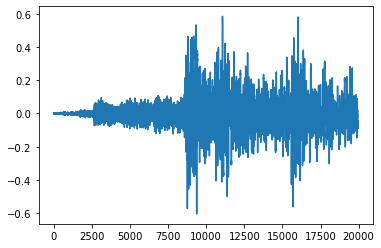

In [105]:
pylab.plot(nnn)

In [124]:
data.shape

torch.Size([10000, 1])